In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import big_model, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius
from funcs.flarefit import log_probability

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

In [2]:
tstamp

'12_12_2019_15_51'

In [3]:
def get_incl(lcs):
    v_rot = lcs['rad'].values*2*np.pi*R_sun / (lcs['Prot_d'].values*u.d)
    vsini = lcs['vsini_kms'].values*u.km/u.s
    e_vsini = lcs['e_vsini_kms'].values*u.km/u.s
    sini = (vsini / v_rot ).decompose()
    #print(sini.decompose(), v_rot.to("km/s"))
    # set values larger than 1 to 1 (must be due to uncertainties in Rstar or vsini):
    #sini[sini.decompose() > 1] = 1.
    incl = np.arcsin(sini.decompose())
    lcs["incl"] = incl
    lcs["incl_err"] = (e_vsini / (v_rot * np.sqrt(1. - sini**2))).decompose()
    return lcs

In [4]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
guesses = pd.read_csv(f"{CWD}/data/summary/results.csv")
props = pd.read_csv(f"{CWD}/data/summary/properties.csv")
#lcs.ID = lcs.ID.astype(int)
#guesses.ID = guesses.ID.astype(int)
guesses

,prefix,ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot,theta_a_init
0,TIC,237880881,6020,298,1331.82418,0.00194,0.77347,0.02975,0.46626,0.01576,8.43,60.0
1,KIC,100004076,10414,886,1358.52754,0.00072,0.49377,0.02388,0.79166,0.06277,8.88,70.0
2,TIC,44984200,3809,135,1588.02740,0.00106,0.65066,0.03073,0.29153,0.00868,2.71,NaN
3,TIC,277539431,4495,394,1641.86831,0.00291,0.89720,0.08459,0.35356,0.03025,4.56,NaN
4,EPIC,212035340,1954494,483655,3437.83750,0.00029,0.05795,0.00631,29.07702,2.06769,4.63,NaN


In [5]:
lcs = lcs.merge(guesses, on=["ID","prefix"], how="outer")
lcs = lcs.merge(props, left_on="ID", right_on="id")

In [6]:
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,dist_err,dist_source,rad,tflux,tlum,kflux,klum,gmag,jmag,kmag
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,0.038400,gaia,0.108176,3.319760e-12,1.119535e+29,6.712990e-13,2.263849e+28,17.8356,13.078,11.771
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,20.512900,mk_dupuy2012,0.115204,6.546160e-13,8.406482e+29,1.394100e-13,1.790276e+29,19.5667,15.894,14.884
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,0.143774,gaia,0.275151,3.492650e-11,8.870689e+30,1.272670e-11,3.232358e+30,14.9796,11.530,10.636
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,0.027472,gaia,0.142339,6.305290e-11,9.308451e+29,2.018160e-11,2.979395e+29,14.4115,10.309,9.268
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,0.106872,gaia,0.145216,5.011190e-11,1.126370e+30,1.380730e-11,3.103479e+29,14.7381,10.630,9.666
5,300741820,8,slc,2,tess,TIC,generic,TESS,NaN,1522.00,...,4.409260,mk_dupuy2012,0.127594,2.711650e-11,1.608939e+30,8.679300e-12,5.149798e+29,15.3277,11.959,11.126


In [8]:
lcs = get_incl(lcs)
lcs.to_csv(f"{CWD}/data/summary/everything.csv", index=False)
target = lcs.iloc[0]
target

ID                              100004076
QCS                                    14
typ                                   slc
cadence_min                             1
mission                               kep
prefix                                KIC
origin                            generic
h_mission                          Kepler
SpT                                    L1
view_start                         1356.5
view_stop                            1361
view_min                              600
view_max                             1050
BJDoff                            2454833
tstart                            1358.55
ampl_min                              NaN
ampl_max                              NaN
RA                                  286.7
Dec                               40.1857
J                                  13.078
R                                     NaN
Gaia_G                            17.8356
vsini_kms                            11.2
e_vsini_kms                       

0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


KIC 100004076 modulation period:  8.880603057671022 h
Relative amplitude of modulation: -6.4e-03
[1337.16931409 1337.16999518 1337.17067637 ... 1371.33072079 1371.33140187
 1371.33208294]
[17.69224 17.69224 17.69224 ... 17.69224 17.69224 17.69224]


654.4331461968876

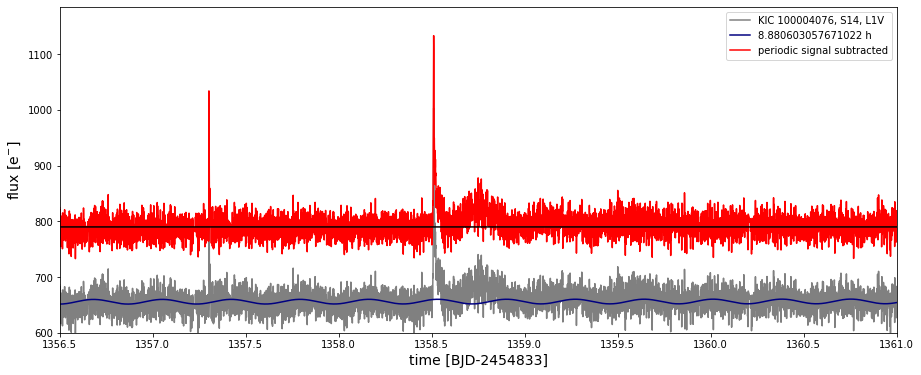

In [17]:
from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
from funcs.custom_detrending import refine_detrended_flux_err
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve

flck = fetch_lightcurve(target)

t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False)
print(t)
F = FlareLightCurve(time=t, detrended_flux=sflux, 
                    detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
print(F.detrended_flux_err)
flcd = refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
                                     std_rolling_window_length=15, pad=25)

choice = (t > target.view_start + 1.7) & (t < target.view_stop-1.5) # only one flare in TIC 237 : + 1.56 - 1.
t = t[choice]
flux = sflux[choice]
flux_err = np.nanmean(flcd.detrended_flux_err)
median = np.nanmean(find_iterative_median(F).it_med)
phi = (t - t[0])/target.Prot_d * 2 * np.pi

pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median}).to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
                                                             index=False)
median

1908

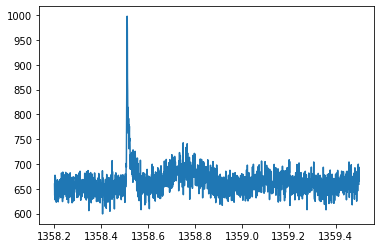

In [18]:
plt.plot(t,flux)
len(t)

In [19]:

#
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median

654.4331461968876

(0.8726646259971648, 0.8594593230103518, 5.351346658776692, 4.654681082365495)

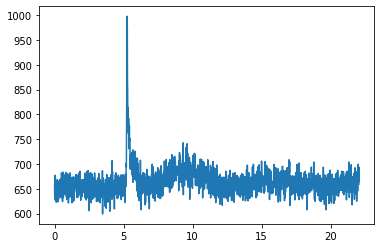

In [45]:

phi_a = (target.t0 - t[0])/target.Prot_d * 2 * np.pi-.2
theta_a = 50*np.pi/180#target.theta_a_init
a = target.ampl*1.2
fwhm = target.dur /target.Prot_d * 2 * np.pi/60
i_mu = target.incl
i_sigma = target.incl_err
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = .8 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = phi[-1]
plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R, 0, 0, np.pi/2, phi0=0)
theta_a, i_mu, phi_a, radius


In [46]:
.86/np.pi*180

49.274370381250804

In [ ]:
plt.plot(phi,flux)
plt.plot(phi, big_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="r", alpha=1,)

### Save inits

In [77]:
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = "date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,median\n"
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},{median}\n")
    f.write(firstout)
    f.write(out)

## Run MCMC

In [78]:

inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 6))
nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                backend=backend)

In [ ]:

sampler.run_mcmc(pos, 5000, progress=True, store=True);

  1%|          | 53/5000 [00:43<1:07:27,  1.22it/s]

prior inf
prior inf


  1%|          | 54/5000 [00:44<1:06:49,  1.23it/s]

prior inf


  1%|          | 56/5000 [00:45<1:08:25,  1.20it/s]

prior inf
prior inf


  1%|          | 58/5000 [00:47<1:08:06,  1.21it/s]

prior inf


  1%|          | 60/5000 [00:49<1:07:32,  1.22it/s]

prior inf


  2%|▏         | 85/5000 [01:09<1:06:01,  1.24it/s]

prior inf


  2%|▏         | 86/5000 [01:10<1:04:50,  1.26it/s]

prior inf


  2%|▏         | 88/5000 [01:11<1:04:16,  1.27it/s]

prior inf


  2%|▏         | 89/5000 [01:12<1:03:58,  1.28it/s]

prior inf


  2%|▏         | 95/5000 [01:17<1:05:33,  1.25it/s]

prior inf


  2%|▏         | 97/5000 [01:18<1:04:03,  1.28it/s]

prior inf


  2%|▏         | 98/5000 [01:19<1:04:23,  1.27it/s]

prior inf
prior inf


  2%|▏         | 100/5000 [01:21<1:02:36,  1.30it/s]

prior inf
prior inf


  2%|▏         | 101/5000 [01:21<1:01:45,  1.32it/s]

prior inf


  2%|▏         | 102/5000 [01:22<1:02:27,  1.31it/s]

prior inf


  2%|▏         | 104/5000 [01:24<1:02:55,  1.30it/s]

prior inf


  2%|▏         | 105/5000 [01:24<1:02:37,  1.30it/s]

prior inf
prior inf
prior inf


  2%|▏         | 106/5000 [01:25<1:02:33,  1.30it/s]

prior inf
prior inf
prior inf


  2%|▏         | 107/5000 [01:26<1:02:50,  1.30it/s]

prior inf
prior inf
prior inf


  2%|▏         | 108/5000 [01:27<1:01:02,  1.34it/s]

prior inf
prior inf
prior inf


  2%|▏         | 109/5000 [01:27<1:01:49,  1.32it/s]

prior inf


  2%|▏         | 110/5000 [01:28<1:01:59,  1.31it/s]

prior inf
prior inf
prior inf
prior inf


  2%|▏         | 111/5000 [01:29<1:01:00,  1.34it/s]

prior inf
prior inf


  2%|▏         | 112/5000 [01:30<1:02:31,  1.30it/s]

prior inf
prior inf


  2%|▏         | 113/5000 [01:31<1:03:53,  1.27it/s]

prior inf
prior inf
prior inf


  2%|▏         | 114/5000 [01:31<1:03:19,  1.29it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  2%|▏         | 115/5000 [01:32<1:00:55,  1.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  2%|▏         | 116/5000 [01:33<1:00:01,  1.36it/s]

prior inf
prior inf
prior inf
prior inf


  2%|▏         | 117/5000 [01:33<59:11,  1.37it/s]  

prior inf
prior inf
prior inf


  2%|▏         | 118/5000 [01:34<55:44,  1.46it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  2%|▏         | 119/5000 [01:35<54:13,  1.50it/s]

prior inf
prior inf
prior inf


  2%|▏         | 120/5000 [01:35<54:03,  1.50it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  2%|▏         | 121/5000 [01:36<49:59,  1.63it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  2%|▏         | 122/5000 [01:36<48:49,  1.67it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  2%|▏         | 123/5000 [01:37<50:06,  1.62it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  2%|▏         | 124/5000 [01:38<50:55,  1.60it/s]

prior inf
prior inf
prior inf
prior inf


  2%|▎         | 125/5000 [01:38<49:35,  1.64it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 126/5000 [01:39<47:25,  1.71it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 127/5000 [01:39<47:56,  1.69it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 128/5000 [01:40<48:39,  1.67it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 129/5000 [01:41<48:46,  1.66it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 130/5000 [01:41<48:49,  1.66it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 131/5000 [01:42<50:01,  1.62it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 132/5000 [01:42<50:39,  1.60it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 133/5000 [01:43<46:36,  1.74it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 134/5000 [01:43<46:44,  1.74it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 135/5000 [01:44<47:27,  1.71it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 136/5000 [01:45<45:22,  1.79it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 137/5000 [01:45<46:30,  1.74it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 138/5000 [01:46<51:54,  1.56it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 139/5000 [01:47<50:58,  1.59it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 140/5000 [01:47<48:00,  1.69it/s]

prior inf
prior inf
prior inf
prior inf


  3%|▎         | 141/5000 [01:48<51:25,  1.57it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 142/5000 [01:49<53:44,  1.51it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 143/5000 [01:49<54:17,  1.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 144/5000 [01:50<50:36,  1.60it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 145/5000 [01:50<48:52,  1.66it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 146/5000 [01:51<47:52,  1.69it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 147/5000 [01:51<47:36,  1.70it/s]

prior inf
prior inf
prior inf


  3%|▎         | 148/5000 [01:52<50:03,  1.62it/s]

prior inf
prior inf
prior inf
prior inf


  3%|▎         | 149/5000 [01:53<50:53,  1.59it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 150/5000 [01:53<49:27,  1.63it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 151/5000 [01:54<48:23,  1.67it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 152/5000 [01:54<46:26,  1.74it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 153/5000 [01:55<45:46,  1.76it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 154/5000 [01:56<45:03,  1.79it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 155/5000 [01:56<45:54,  1.76it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 156/5000 [01:57<43:31,  1.85it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 157/5000 [01:57<43:49,  1.84it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 158/5000 [01:58<46:51,  1.72it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 159/5000 [01:58<45:57,  1.76it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 160/5000 [01:59<42:45,  1.89it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 161/5000 [01:59<40:24,  2.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 162/5000 [02:00<43:08,  1.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 163/5000 [02:00<44:21,  1.82it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 164/5000 [02:01<40:45,  1.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 165/5000 [02:01<41:25,  1.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 166/5000 [02:02<40:54,  1.97it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 167/5000 [02:02<43:10,  1.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 168/5000 [02:03<45:25,  1.77it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 169/5000 [02:04<43:37,  1.85it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 170/5000 [02:04<43:55,  1.83it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 171/5000 [02:05<41:29,  1.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 172/5000 [02:05<42:43,  1.88it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 173/5000 [02:06<42:22,  1.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  3%|▎         | 174/5000 [02:06<40:29,  1.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▎         | 175/5000 [02:07<41:37,  1.93it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▎         | 176/5000 [02:07<40:48,  1.97it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▎         | 177/5000 [02:08<40:40,  1.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▎         | 178/5000 [02:08<40:18,  1.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▎         | 179/5000 [02:09<38:53,  2.07it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▎         | 180/5000 [02:09<41:35,  1.93it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▎         | 181/5000 [02:10<39:27,  2.04it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▎         | 182/5000 [02:10<40:19,  1.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▎         | 183/5000 [02:11<41:59,  1.91it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▎         | 184/5000 [02:11<40:47,  1.97it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▎         | 185/5000 [02:12<42:15,  1.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▎         | 186/5000 [02:12<41:59,  1.91it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▎         | 187/5000 [02:13<40:41,  1.97it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 188/5000 [02:13<40:07,  2.00it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 189/5000 [02:14<42:18,  1.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 190/5000 [02:14<42:19,  1.89it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 191/5000 [02:15<43:58,  1.82it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 192/5000 [02:16<44:52,  1.79it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 193/5000 [02:16<46:56,  1.71it/s]

prior inf
prior inf
prior inf


  4%|▍         | 194/5000 [02:17<45:34,  1.76it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 195/5000 [02:17<41:37,  1.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 196/5000 [02:18<42:44,  1.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 197/5000 [02:18<41:02,  1.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 198/5000 [02:19<41:25,  1.93it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 199/5000 [02:19<42:04,  1.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 200/5000 [02:20<43:49,  1.83it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 201/5000 [02:20<44:51,  1.78it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 202/5000 [02:21<44:40,  1.79it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 203/5000 [02:22<45:02,  1.78it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 204/5000 [02:22<43:50,  1.82it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 205/5000 [02:22<41:02,  1.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 206/5000 [02:23<42:50,  1.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 207/5000 [02:24<43:53,  1.82it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 208/5000 [02:24<44:03,  1.81it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 209/5000 [02:25<40:04,  1.99it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 210/5000 [02:25<40:19,  1.98it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 211/5000 [02:26<41:15,  1.93it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 212/5000 [02:26<41:24,  1.93it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 213/5000 [02:27<43:07,  1.85it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 214/5000 [02:27<41:56,  1.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 215/5000 [02:28<42:51,  1.86it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 216/5000 [02:28<42:47,  1.86it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 217/5000 [02:29<43:41,  1.82it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 218/5000 [02:29<42:53,  1.86it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 219/5000 [02:30<41:32,  1.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 220/5000 [02:30<41:48,  1.91it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 221/5000 [02:31<41:58,  1.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 222/5000 [02:32<44:27,  1.79it/s]

prior inf
prior inf
prior inf
prior inf


  4%|▍         | 223/5000 [02:32<47:04,  1.69it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 224/5000 [02:33<45:24,  1.75it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  4%|▍         | 225/5000 [02:33<44:12,  1.80it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 226/5000 [02:34<42:29,  1.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 227/5000 [02:34<43:30,  1.83it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 228/5000 [02:35<41:56,  1.90it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 229/5000 [02:35<42:33,  1.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 230/5000 [02:36<43:09,  1.84it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 231/5000 [02:37<42:14,  1.88it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 232/5000 [02:37<42:03,  1.89it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 233/5000 [02:38<41:02,  1.94it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 234/5000 [02:38<43:11,  1.84it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 235/5000 [02:39<46:42,  1.70it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 236/5000 [02:39<46:29,  1.71it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 237/5000 [02:40<45:40,  1.74it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 238/5000 [02:41<45:32,  1.74it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 239/5000 [02:41<43:46,  1.81it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 240/5000 [02:41<41:35,  1.91it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 241/5000 [02:42<42:06,  1.88it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 242/5000 [02:43<42:19,  1.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 243/5000 [02:43<41:13,  1.92it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 244/5000 [02:44<43:11,  1.84it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 245/5000 [02:44<45:56,  1.73it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 246/5000 [02:45<44:58,  1.76it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 247/5000 [02:45<43:10,  1.83it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 248/5000 [02:46<42:32,  1.86it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▍         | 249/5000 [02:46<42:30,  1.86it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 250/5000 [02:47<44:10,  1.79it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 251/5000 [02:48<44:16,  1.79it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 252/5000 [02:48<44:24,  1.78it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 253/5000 [02:49<42:29,  1.86it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 254/5000 [02:49<45:35,  1.74it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 255/5000 [02:50<46:14,  1.71it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 256/5000 [02:50<44:11,  1.79it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 257/5000 [02:51<43:10,  1.83it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 258/5000 [02:51<42:13,  1.87it/s]

prior inf
prior inf
prior inf
prior inf


  5%|▌         | 259/5000 [02:52<44:13,  1.79it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 260/5000 [02:53<44:35,  1.77it/s]

prior inf
prior inf
prior inf
prior inf


  5%|▌         | 261/5000 [02:53<47:26,  1.66it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 262/5000 [02:54<44:42,  1.77it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 263/5000 [02:54<43:32,  1.81it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 264/5000 [02:55<44:32,  1.77it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 265/5000 [02:56<45:49,  1.72it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 266/5000 [02:56<41:17,  1.91it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 267/5000 [02:56<41:55,  1.88it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 268/5000 [02:57<42:51,  1.84it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 269/5000 [02:57<40:12,  1.96it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 270/5000 [02:58<43:21,  1.82it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 271/5000 [02:59<43:07,  1.83it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 272/5000 [02:59<40:24,  1.95it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 273/5000 [03:00<41:15,  1.91it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  5%|▌         | 274/5000 [03:00<43:48,  1.80it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 275/5000 [03:01<44:21,  1.78it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 276/5000 [03:01<42:03,  1.87it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 277/5000 [03:02<43:35,  1.81it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 278/5000 [03:02<43:59,  1.79it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 279/5000 [03:03<48:04,  1.64it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 280/5000 [03:04<45:03,  1.75it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 281/5000 [03:04<44:47,  1.76it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 282/5000 [03:05<45:05,  1.74it/s]

prior inf
prior inf
prior inf


  6%|▌         | 283/5000 [03:05<47:08,  1.67it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 284/5000 [03:06<45:45,  1.72it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 285/5000 [03:07<47:31,  1.65it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 286/5000 [03:07<47:13,  1.66it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 287/5000 [03:08<47:24,  1.66it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 288/5000 [03:08<47:07,  1.67it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 289/5000 [03:09<44:54,  1.75it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 290/5000 [03:10<46:53,  1.67it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 291/5000 [03:10<45:55,  1.71it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 292/5000 [03:11<46:29,  1.69it/s]

prior inf
prior inf
prior inf
prior inf


  6%|▌         | 293/5000 [03:12<49:05,  1.60it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 294/5000 [03:12<47:34,  1.65it/s]

prior inf
prior inf
prior inf
prior inf


  6%|▌         | 295/5000 [03:13<47:45,  1.64it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 296/5000 [03:13<47:56,  1.64it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 297/5000 [03:14<46:34,  1.68it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 298/5000 [03:14<45:44,  1.71it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 299/5000 [03:15<46:10,  1.70it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 300/5000 [03:16<46:41,  1.68it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 301/5000 [03:16<47:04,  1.66it/s]

prior inf
prior inf


  6%|▌         | 302/5000 [03:17<48:59,  1.60it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 303/5000 [03:18<49:19,  1.59it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 304/5000 [03:18<49:36,  1.58it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 305/5000 [03:19<50:12,  1.56it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 306/5000 [03:20<51:09,  1.53it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 307/5000 [03:20<48:50,  1.60it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 308/5000 [03:21<49:49,  1.57it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 309/5000 [03:21<48:42,  1.61it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 310/5000 [03:22<50:53,  1.54it/s]

prior inf
prior inf


  6%|▌         | 311/5000 [03:23<54:24,  1.44it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▌         | 312/5000 [03:24<55:16,  1.41it/s]

prior inf
prior inf
prior inf


  6%|▋         | 313/5000 [03:24<55:14,  1.41it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▋         | 314/5000 [03:25<52:19,  1.49it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▋         | 315/5000 [03:26<52:57,  1.47it/s]

prior inf
prior inf
prior inf
prior inf


  6%|▋         | 316/5000 [03:26<53:28,  1.46it/s]

prior inf
prior inf
prior inf


  6%|▋         | 317/5000 [03:27<56:38,  1.38it/s]

prior inf
prior inf
prior inf
prior inf


  6%|▋         | 318/5000 [03:28<57:18,  1.36it/s]

prior inf
prior inf
prior inf


  6%|▋         | 319/5000 [03:29<58:29,  1.33it/s]

prior inf
prior inf
prior inf


  6%|▋         | 320/5000 [03:29<58:37,  1.33it/s]

prior inf
prior inf
prior inf


  6%|▋         | 321/5000 [03:30<57:22,  1.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▋         | 322/5000 [03:31<58:21,  1.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  6%|▋         | 323/5000 [03:32<57:26,  1.36it/s]

prior inf
prior inf
prior inf
prior inf


  6%|▋         | 324/5000 [03:32<57:23,  1.36it/s]

prior inf
prior inf
prior inf
prior inf


  6%|▋         | 325/5000 [03:33<57:14,  1.36it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 326/5000 [03:34<55:33,  1.40it/s]

prior inf
prior inf
prior inf


  7%|▋         | 327/5000 [03:34<56:12,  1.39it/s]

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 328/5000 [03:35<58:05,  1.34it/s]

prior inf
prior inf
prior inf


  7%|▋         | 329/5000 [03:36<58:11,  1.34it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 330/5000 [03:37<55:47,  1.40it/s]

prior inf
prior inf
prior inf


  7%|▋         | 331/5000 [03:37<58:04,  1.34it/s]

prior inf
prior inf
prior inf


  7%|▋         | 332/5000 [03:38<59:04,  1.32it/s]

prior inf
prior inf
prior inf


  7%|▋         | 333/5000 [03:39<58:52,  1.32it/s]

prior inf
prior inf


  7%|▋         | 334/5000 [03:40<58:33,  1.33it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 335/5000 [03:41<58:45,  1.32it/s]

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 336/5000 [03:41<58:54,  1.32it/s]

prior inf


  7%|▋         | 337/5000 [03:42<59:58,  1.30it/s]

prior inf
prior inf


  7%|▋         | 338/5000 [03:43<1:00:21,  1.29it/s]

prior inf
prior inf


  7%|▋         | 339/5000 [03:44<1:00:07,  1.29it/s]

prior inf
prior inf
prior inf


  7%|▋         | 340/5000 [03:44<58:48,  1.32it/s]  

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 341/5000 [03:45<56:45,  1.37it/s]

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 342/5000 [03:46<56:50,  1.37it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 343/5000 [03:47<56:22,  1.38it/s]

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 344/5000 [03:47<56:24,  1.38it/s]

prior inf
prior inf


  7%|▋         | 345/5000 [03:48<57:14,  1.36it/s]

prior inf
prior inf


  7%|▋         | 346/5000 [03:49<57:13,  1.36it/s]

prior inf


  7%|▋         | 347/5000 [03:50<1:00:22,  1.28it/s]

prior inf
prior inf


  7%|▋         | 348/5000 [03:50<1:01:27,  1.26it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 349/5000 [03:51<1:00:37,  1.28it/s]

prior inf
prior inf
prior inf


  7%|▋         | 351/5000 [03:53<1:02:54,  1.23it/s]

prior inf
prior inf
prior inf


  7%|▋         | 352/5000 [03:54<1:02:15,  1.24it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 353/5000 [03:54<58:27,  1.32it/s]  

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 354/5000 [03:55<57:23,  1.35it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


  7%|▋         | 355/5000 [03:56<56:10,  1.38it/s]

prior inf
prior inf
prior inf


  7%|▋         | 356/5000 [03:56<56:34,  1.37it/s]

prior inf
prior inf


  7%|▋         | 357/5000 [03:57<57:50,  1.34it/s]

prior inf
prior inf


  7%|▋         | 359/5000 [03:59<58:27,  1.32it/s]

prior inf
prior inf
prior inf


  7%|▋         | 360/5000 [04:00<59:02,  1.31it/s]

prior inf
prior inf


  7%|▋         | 361/5000 [04:00<57:43,  1.34it/s]

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 363/5000 [04:02<59:36,  1.30it/s]

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 365/5000 [04:03<59:57,  1.29it/s]  

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 366/5000 [04:04<1:00:20,  1.28it/s]

prior inf


  7%|▋         | 368/5000 [04:06<1:00:49,  1.27it/s]

prior inf
prior inf
prior inf
prior inf


  7%|▋         | 369/5000 [04:07<1:00:19,  1.28it/s]

prior inf
prior inf


  7%|▋         | 370/5000 [04:07<1:00:58,  1.27it/s]

prior inf


  7%|▋         | 371/5000 [04:08<1:01:03,  1.26it/s]

prior inf
prior inf


  7%|▋         | 373/5000 [04:10<1:01:53,  1.25it/s]

prior inf
prior inf


  7%|▋         | 374/5000 [04:11<1:02:18,  1.24it/s]

prior inf
prior inf


  8%|▊         | 375/5000 [04:11<1:01:29,  1.25it/s]

prior inf
prior inf
prior inf


  8%|▊         | 376/5000 [04:12<1:01:12,  1.26it/s]

prior inf


  8%|▊         | 377/5000 [04:13<1:00:38,  1.27it/s]

prior inf


  8%|▊         | 378/5000 [04:14<1:00:40,  1.27it/s]

prior inf
prior inf
prior inf


  8%|▊         | 379/5000 [04:14<58:24,  1.32it/s]  

prior inf
prior inf
prior inf
prior inf
prior inf


  8%|▊         | 380/5000 [04:15<58:37,  1.31it/s]

prior inf


  8%|▊         | 381/5000 [04:16<59:44,  1.29it/s]

prior inf


  8%|▊         | 382/5000 [04:17<1:00:25,  1.27it/s]

prior inf


  8%|▊         | 383/5000 [04:18<1:00:30,  1.27it/s]

prior inf
prior inf
prior inf


  8%|▊         | 384/5000 [04:18<59:52,  1.28it/s]  

prior inf
prior inf


  8%|▊         | 385/5000 [04:19<59:31,  1.29it/s]

prior inf
prior inf
prior inf


  8%|▊         | 386/5000 [04:20<58:51,  1.31it/s]

prior inf
prior inf
prior inf


  8%|▊         | 387/5000 [04:21<58:24,  1.32it/s]

prior inf
prior inf


  8%|▊         | 388/5000 [04:21<58:45,  1.31it/s]

prior inf
prior inf


  8%|▊         | 389/5000 [04:22<58:45,  1.31it/s]

prior inf


  8%|▊         | 392/5000 [04:25<1:01:27,  1.25it/s]

prior inf


  8%|▊         | 397/5000 [04:29<1:03:36,  1.21it/s]

prior inf
prior inf


  8%|▊         | 398/5000 [04:30<1:03:52,  1.20it/s]

prior inf
prior inf


  8%|▊         | 399/5000 [04:30<1:03:11,  1.21it/s]

prior inf


  8%|▊         | 401/5000 [04:32<1:04:03,  1.20it/s]

prior inf
prior inf
prior inf


  8%|▊         | 404/5000 [04:35<1:03:07,  1.21it/s]

prior inf


  8%|▊         | 406/5000 [04:36<1:03:20,  1.21it/s]

prior inf
prior inf


  8%|▊         | 407/5000 [04:37<1:01:28,  1.25it/s]

prior inf


  8%|▊         | 408/5000 [04:38<1:02:26,  1.23it/s]

prior inf


  8%|▊         | 410/5000 [04:39<1:02:32,  1.22it/s]

prior inf


  8%|▊         | 412/5000 [04:41<1:02:02,  1.23it/s]

prior inf
prior inf


  8%|▊         | 413/5000 [04:42<1:01:08,  1.25it/s]

prior inf
prior inf


  8%|▊         | 415/5000 [04:43<1:01:57,  1.23it/s]

prior inf


  8%|▊         | 419/5000 [04:47<1:03:31,  1.20it/s]

prior inf


  8%|▊         | 422/5000 [04:49<1:02:22,  1.22it/s]

prior inf
prior inf


  9%|▊         | 432/5000 [04:58<1:05:29,  1.16it/s]

prior inf


  9%|▉         | 461/5000 [05:22<1:03:28,  1.19it/s]

prior inf


  9%|▉         | 463/5000 [05:24<1:05:36,  1.15it/s]

prior inf


  9%|▉         | 466/5000 [05:26<1:04:15,  1.18it/s]

prior inf


  9%|▉         | 468/5000 [05:28<1:03:52,  1.18it/s]

prior inf


  9%|▉         | 469/5000 [05:29<1:03:32,  1.19it/s]

prior inf
prior inf


  9%|▉         | 472/5000 [05:31<1:04:09,  1.18it/s]

prior inf


  9%|▉         | 474/5000 [05:33<1:03:22,  1.19it/s]

prior inf


 10%|▉         | 476/5000 [05:35<1:03:29,  1.19it/s]

prior inf
prior inf


 10%|▉         | 478/5000 [05:36<1:03:18,  1.19it/s]

prior inf
prior inf


 10%|▉         | 479/5000 [05:37<1:01:47,  1.22it/s]

prior inf
prior inf


 10%|▉         | 480/5000 [05:38<1:00:25,  1.25it/s]

prior inf
prior inf


 10%|▉         | 484/5000 [05:41<1:02:13,  1.21it/s]

prior inf


 10%|▉         | 485/5000 [05:42<1:01:56,  1.21it/s]

prior inf


 10%|▉         | 490/5000 [05:46<1:02:36,  1.20it/s]

prior inf


 10%|█         | 503/5000 [05:57<1:02:34,  1.20it/s]

prior inf


 10%|█         | 507/5000 [06:00<1:02:24,  1.20it/s]

prior inf


 10%|█         | 508/5000 [06:01<1:01:31,  1.22it/s]

prior inf
prior inf


 10%|█         | 511/5000 [06:03<1:00:58,  1.23it/s]

prior inf


 11%|█         | 542/5000 [06:29<1:02:40,  1.19it/s]

prior inf


 11%|█         | 556/5000 [06:41<1:01:12,  1.21it/s]

prior inf


 15%|█▍        | 727/5000 [09:05<58:54,  1.21it/s]  

prior inf


 15%|█▍        | 728/5000 [09:05<58:41,  1.21it/s]

prior inf
prior inf


 15%|█▍        | 730/5000 [09:07<58:55,  1.21it/s]

prior inf


 15%|█▍        | 734/5000 [09:11<1:01:24,  1.16it/s]

prior inf


 15%|█▍        | 735/5000 [09:11<1:00:40,  1.17it/s]

prior inf


 15%|█▍        | 737/5000 [09:13<1:00:59,  1.16it/s]

prior inf
prior inf


 15%|█▍        | 738/5000 [09:14<59:34,  1.19it/s]  

prior inf


 15%|█▍        | 739/5000 [09:15<59:17,  1.20it/s]

prior inf
prior inf
prior inf


 15%|█▍        | 740/5000 [09:16<57:20,  1.24it/s]

prior inf


 15%|█▍        | 741/5000 [09:16<58:19,  1.22it/s]

prior inf


 15%|█▍        | 742/5000 [09:17<57:43,  1.23it/s]

prior inf
prior inf


 15%|█▍        | 743/5000 [09:18<57:13,  1.24it/s]

prior inf
prior inf
prior inf


 15%|█▍        | 744/5000 [09:19<56:54,  1.25it/s]

prior inf


 15%|█▍        | 745/5000 [09:20<57:36,  1.23it/s]

prior inf


 15%|█▍        | 748/5000 [09:22<59:36,  1.19it/s]

prior inf


 15%|█▌        | 752/5000 [09:26<59:33,  1.19it/s]

prior inf


 15%|█▌        | 755/5000 [09:28<58:10,  1.22it/s]

prior inf


 15%|█▌        | 756/5000 [09:29<57:30,  1.23it/s]

prior inf


 15%|█▌        | 757/5000 [09:30<56:59,  1.24it/s]

prior inf


 15%|█▌        | 758/5000 [09:30<57:23,  1.23it/s]

prior inf
prior inf


 15%|█▌        | 759/5000 [09:31<56:25,  1.25it/s]

prior inf


 15%|█▌        | 760/5000 [09:32<56:33,  1.25it/s]

prior inf


 15%|█▌        | 762/5000 [09:34<57:54,  1.22it/s]

prior inf


 15%|█▌        | 763/5000 [09:34<57:14,  1.23it/s]

prior inf
prior inf
prior inf


 15%|█▌        | 764/5000 [09:35<56:57,  1.24it/s]

prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 765/5000 [09:36<57:20,  1.23it/s]

prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 766/5000 [09:37<57:03,  1.24it/s]

prior inf
prior inf
prior inf


 15%|█▌        | 767/5000 [09:38<56:27,  1.25it/s]

prior inf
prior inf
prior inf


 15%|█▌        | 768/5000 [09:38<55:08,  1.28it/s]

prior inf
prior inf


 15%|█▌        | 769/5000 [09:39<54:47,  1.29it/s]

prior inf


 15%|█▌        | 770/5000 [09:40<54:56,  1.28it/s]

prior inf
prior inf
prior inf
prior inf
prior inf
prior inf
prior inf


 15%|█▌        | 771/5000 [09:41<53:16,  1.32it/s]

prior inf
prior inf
prior inf


 15%|█▌        | 772/5000 [09:41<53:03,  1.33it/s]

prior inf
prior inf


 15%|█▌        | 773/5000 [09:42<53:26,  1.32it/s]

prior inf


 15%|█▌        | 774/5000 [09:43<53:27,  1.32it/s]

prior inf


 16%|█▌        | 775/5000 [09:44<53:57,  1.31it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 776/5000 [09:44<53:43,  1.31it/s]

prior inf
prior inf
prior inf


 16%|█▌        | 778/5000 [09:46<56:38,  1.24it/s]

prior inf
prior inf


 16%|█▌        | 779/5000 [09:47<57:28,  1.22it/s]

prior inf


 16%|█▌        | 780/5000 [09:48<58:37,  1.20it/s]

prior inf


 16%|█▌        | 781/5000 [09:49<58:43,  1.20it/s]

prior inf


 16%|█▌        | 782/5000 [09:50<58:34,  1.20it/s]

prior inf


 16%|█▌        | 783/5000 [09:50<58:59,  1.19it/s]

prior inf


 16%|█▌        | 785/5000 [09:52<58:41,  1.20it/s]

prior inf


 16%|█▌        | 790/5000 [09:56<58:41,  1.20it/s]

prior inf


 16%|█▌        | 793/5000 [09:59<57:50,  1.21it/s]

prior inf


 16%|█▌        | 796/5000 [10:01<59:28,  1.18it/s]

prior inf


 16%|█▌        | 799/5000 [10:04<59:35,  1.17it/s]  

prior inf


 16%|█▌        | 801/5000 [10:06<59:41,  1.17it/s]

prior inf


 16%|█▌        | 804/5000 [10:08<58:12,  1.20it/s]

prior inf
prior inf


 16%|█▌        | 805/5000 [10:09<57:16,  1.22it/s]

prior inf


 16%|█▌        | 807/5000 [10:10<56:30,  1.24it/s]

prior inf


 16%|█▌        | 808/5000 [10:11<57:04,  1.22it/s]

prior inf


 16%|█▋        | 820/5000 [10:22<1:04:04,  1.09it/s]

prior inf


 17%|█▋        | 838/5000 [10:37<56:24,  1.23it/s]  

prior inf


 17%|█▋        | 843/5000 [10:41<57:56,  1.20it/s]

prior inf


 95%|█████████▌| 4762/5000 [1:05:05<03:19,  1.20it/s]

In [ ]:
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"

new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))

In [ ]:
new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                    backend=new_backend)
new_sampler.run_mcmc(None, 100)
print("Final size: {0}".format(new_backend.iteration))

In [ ]:
# DEPRECATED SNIPPETS
# def t0_ED(x):
#     return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
# def dur_ED(x):
#     return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
# def ampl_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
# def median_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
# E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
# E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
# E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
# E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
# np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

# check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
# assert E_median == pytest.approx(E_median,rel=1e-4)
# e_median, median

# EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
# e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
# EDval,e_ED